# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

Answer: This is a classification problem since the output can be modeled as a categorical binary variable with 1 as student needs intervention and 0 if they don't.

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [85]:
# Import libraries
import numpy as np
import pandas as pd

In [86]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print ("Student data read successfully!")
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [87]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = len(student_data)
n_features = len(student_data.columns)-1
n_passed = len(student_data.passed[student_data.passed=='yes'])
n_failed = len(student_data.passed[student_data.passed=='no'])
grad_rate = n_passed/n_students * 100
print ("Total number of students: {}".format(n_students))
print ("Number of students who passed: {}".format(n_passed))
print ("Number of students who failed: {}".format(n_failed))
print ("Number of features: {}".format(n_features))
print ("Graduation rate of the class: {:.2f}%".format(grad_rate))

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [88]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print ("Feature column(s):-\n{}".format(feature_cols))
print ("Target column: {}".format(target_col))

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print ("\nFeature values:-")
print (X_all.head())  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [89]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print ("Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [90]:
from sklearn.cross_validation import train_test_split

In [93]:
# First, decide how many training vs test samples you want
from sklearn.cross_validation import train_test_split
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.24, random_state=12) 

print ("Training set: {} samples".format(X_train.shape[0]))
print ("Test set: {} samples".format(X_test.shape[0]))
# Note: If you need a validation set, extract it from within training data

Training set: 300 samples
Test set: 95 samples


## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What is the theoretical O(n) time & space complexity in terms of input size?
- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

In [95]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    print ("Training {}...".format(clf.__class__.__name__))
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print ("Done!\nTraining time (secs): {:.3f}".format(end - start))

# TODO: Choose a model, import it and instantiate an object
from sklearn.svm import SVC
clf = SVC(kernel='rbf', C=1.0, random_state=0)


# Fit model to training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here
#print clf  # you can inspect the learned model by printing it

Training SVC...
Done!
Training time (secs): 0.005


In [97]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    print ("Predicting labels using {}...".format(clf.__class__.__name__))
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print ("Done!\nPrediction time (secs): {:.3f}".format(end - start))
    return f1_score(target.values, y_pred, pos_label='yes')

train_f1_score = predict_labels(clf, X_train, y_train)
print ("F1 score for training set: {}".format(train_f1_score))

Predicting labels using SVC...
Done!
Prediction time (secs): 0.004
F1 score for training set: 0.8761061946902654


In [98]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print ("------------------------------------------")
    print ("Training set size: {}".format(len(X_train)))
    train_classifier(clf, X_train, y_train)
    print ("F1 score for training set: {}".format(predict_labels(clf, X_train, y_train)))
    print ("F1 score for test set: {}".format(predict_labels(clf, X_test, y_test)))

# TODO: Run the helper function above for desired subsets of training data
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=300, test_size=95, random_state=420) 
train_predict(clf, X_train, y_train, X_test, y_test)

# Note: Keep the test set constant

------------------------------------------
Training set size: 300
Training SVC...
Done!
Training time (secs): 0.006
Predicting labels using SVC...
Done!
Prediction time (secs): 0.004
F1 score for training set: 0.8589473684210527
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.7972972972972973


# Support Vector Machine (RBF kernel)

- Core of SVM is a quadratic programming problem. Complexity of QP solver used by libsvm scales between O(Nfeatures Ndata^2) and O(Nfeatures Ndata^2)

- It is used for classification, regression, and outlier detection. Heavily used in computer vision 

#### Strengths 

- It is effective in high dimensional space

- Is mostly effective even when there are more features than number of data points 

- Since it uses only a subset of training points in the decision function its memory is efficient 

#### Weaknesses

- They do not directly provide probability estimates but using probability=True in the code it can be computed. However it is a slow process since its calculated one-vs-rest.

- Their output are distance based and so cannot be interpreted directly.

I have decided to use SVM for this problem since its a state of the art classification algorithm widely used. Since SVM works better when data instances are more than the number of features. 


In [64]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', C=1.0, random_state=10)

X_train100 = X_train[:100]
y_train100 = y_train[:100]
train_predict(clf, X_train100, y_train100, X_test, y_test)

X_train200 = X_train[:200]
y_train200 = y_train[:200]
train_predict(clf, X_train200, y_train200, X_test, y_test)

X_train300 = X_train[:300]
y_train300 = y_train[:300] 
train_predict(clf, X_train300, y_train300, X_test, y_test)



------------------------------------------
Training set size: 100
Training SVC...
Done!
Training time (secs): 0.011
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.8662420382165604
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.7999999999999999
------------------------------------------
Training set size: 200
Training SVC...
Done!
Training time (secs): 0.018
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for training set: 0.8469055374592833
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.7916666666666666
------------------------------------------
Training set size: 300
Training SVC...
Done!
Training time (secs): 0.006
Predicting labels using SVC...
Done!
Prediction time (secs): 0.004
F1 score for training set: 0.8589473684210527
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.797

In [105]:
class ListTable(list):
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
import random
table = ListTable()
table.append(['Training set size','Train time', 'Pred time', 'F1 score train', 'F1 score test'])

print ("Table for SVM")
table.append([100,0.011,0.001,0.87,0.8])
table.append([200,0.018,0.002,0.85,0.80])
table.append([300,0.006,0.002,0.86,0.80])
table

Table for SVM


Training set size,Train time,Pred time,F1 score train,F1 score test
100,0.011,0.001,0.87,0.8
200,0.018,0.002,0.85,0.8
300,0.006,0.002,0.86,0.8


# AdaBoost

- Complexity of AdaBoost is O(T f) where T is the number of weak learner and f is the runtime of the weak learner in use. Usually a decision tree is used as a weak learner with complexity O(n d^2) where n is the number of samples and d is feature dimension.

- It is used for classification, regression, and outlier detection in text categorization and other computer vision applications 

#### Strengths

- In some problems AdaBoost is less susceptible to the problem of overfitting than other learning algorithms

- Its versatile and can be used with data that is textual, numeric, discrete etc

- Feature importance can also be found with AdaBoost which is important when one wants good interpretation of the predictors and not just the prediction power of the model.  

- Its fast, simple and easy to program 

- It can combine with any classifier to find weak hypothesis 

#### Weaknesses

- It is sensitive to noisy data and outliers 

- Weak classifiers with error rate greater than 0.5 can lead to low margins and overfitting 

Since AdaBoost is an ensemble method which averages out the bias, reduce the variance, and unlikely to overfit I am using it for the current problem of classification  



In [106]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=20)

X_train100 = X_train[:100]
y_train100 = y_train[:100]
train_predict(clf, X_train100, y_train100, X_test, y_test)

X_train200 = X_train[:200]
y_train200 = y_train[:200]
train_predict(clf, X_train200, y_train200, X_test, y_test)

X_train300 = X_train[:300]
y_train300 = y_train[:300] 
train_predict(clf, X_train300, y_train300, X_test, y_test)



------------------------------------------
Training set size: 100
Training AdaBoostClassifier...
Done!
Training time (secs): 0.092
Predicting labels using AdaBoostClassifier...
Done!
Prediction time (secs): 0.009
F1 score for training set: 0.9855072463768115
Predicting labels using AdaBoostClassifier...
Done!
Prediction time (secs): 0.009
F1 score for test set: 0.7716535433070867
------------------------------------------
Training set size: 200
Training AdaBoostClassifier...
Done!
Training time (secs): 0.100
Predicting labels using AdaBoostClassifier...
Done!
Prediction time (secs): 0.010
F1 score for training set: 0.8644688644688645
Predicting labels using AdaBoostClassifier...
Done!
Prediction time (secs): 0.011
F1 score for test set: 0.7716535433070867
------------------------------------------
Training set size: 300
Training AdaBoostClassifier...
Done!
Training time (secs): 0.112
Predicting labels using AdaBoostClassifier...
Done!
Prediction time (secs): 0.012
F1 score for training

In [107]:
import random
table = ListTable()
table.append(['Training set size','Train time', 'Pred time', 'F1 score train', 'F1 score test'])

print ("Table for AdaBoost")
table.append([100,0.092,0.009,0.986,0.77])
table.append([200,0.1,0.011,0.86,0.77])
table.append([300,0.112,0.009,0.87,0.74])
table

Table for AdaBoost


Training set size,Train time,Pred time,F1 score train,F1 score test
100,0.092,0.009,0.986,0.77
200,0.1,0.011,0.86,0.77
300,0.112,0.009,0.87,0.74


# Naive Bayes (BernoulliNB)

- Naive Bayes has a complexity of O(n d) where n is the number of samples and d is number of features 

- It is heavily used for classification in areas such as text classification and spam filtering 

#### Strenghts 

- Inspite of over-simplification naive bayes classifier work well in many real world situations 

- They require small amount of training data to estimate the necessary parameters 

- It is extremely fast compared to more sophisticated methods 

#### Weaknesses 

- Assumes independence of features

Naive bayes has the assumption of independent features and looking at student_data its safe to assume that many features are independent.   

In [108]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()

X_train100 = X_train[:100]
y_train100 = y_train[:100]
train_predict(clf, X_train100, y_train100, X_test, y_test)

X_train200 = X_train[:200]
y_train200 = y_train[:200]
train_predict(clf, X_train200, y_train200, X_test, y_test)

X_train300 = X_train[:300]
y_train300 = y_train[:300] 
train_predict(clf, X_train300, y_train300, X_test, y_test)



------------------------------------------
Training set size: 100
Training BernoulliNB...
Done!
Training time (secs): 0.001
Predicting labels using BernoulliNB...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.8201438848920864
Predicting labels using BernoulliNB...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.7424242424242424
------------------------------------------
Training set size: 200
Training BernoulliNB...
Done!
Training time (secs): 0.016
Predicting labels using BernoulliNB...
Done!
Prediction time (secs): 0.003
F1 score for training set: 0.7889273356401384
Predicting labels using BernoulliNB...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.7727272727272727
------------------------------------------
Training set size: 300
Training BernoulliNB...
Done!
Training time (secs): 0.005
Predicting labels using BernoulliNB...
Done!
Prediction time (secs): 0.005
F1 score for training set: 0.8154897494305239
Predicting labels using Bernoul

In [109]:
import random
table = ListTable()
table.append(['Training set size','Train time', 'Pred time', 'F1 score train', 'F1 score test'])

print ("Table for Naive Bayes")
table.append([100,0.01,0.01,0.82,0.74])
table.append([200,0.016,0.0,0.79,0.77])
table.append([300,0.005,0.0,0.815,0.76])
table

Table for Naive Bayes


Training set size,Train time,Pred time,F1 score train,F1 score test
100,0.01,0.01,0.82,0.74
200,0.016,0.0,0.79,0.77
300,0.005,0.0,0.815,0.76


## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

In [110]:
# TODO: Fine-tune your model and report the best F1 score
from sklearn.grid_search import GridSearchCV
parameters = {'C':[1.0,2.0,3.0,4.0,5.0,10.0]}
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

from sklearn.svm import SVC
clf = SVC(kernel='rbf', random_state=0)

from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

f1_scorer = make_scorer(f1_score, pos_label="yes")

grid=GridSearchCV(estimator = clf, param_grid=param_grid, scoring=f1_scorer)
grid.fit(X_train, y_train)
print(grid)
print(grid.best_estimator_.C)



GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']}, {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001]}],
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(f1_score, pos_label=yes), verbose=0)
100


In [112]:
print(grid.best_estimator_.gamma)


0.0001


In [114]:
train_predict(grid,X_train,y_train,X_test,y_test) 

------------------------------------------
Training set size: 300
Training GridSearchCV...
Done!
Training time (secs): 52.061
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.004
F1 score for training set: 0.8204081632653061
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.8163265306122448


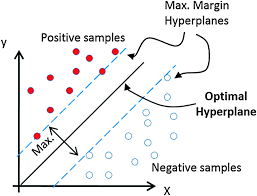

In [73]:
from IPython.display import Image
Image(filename='images.png')


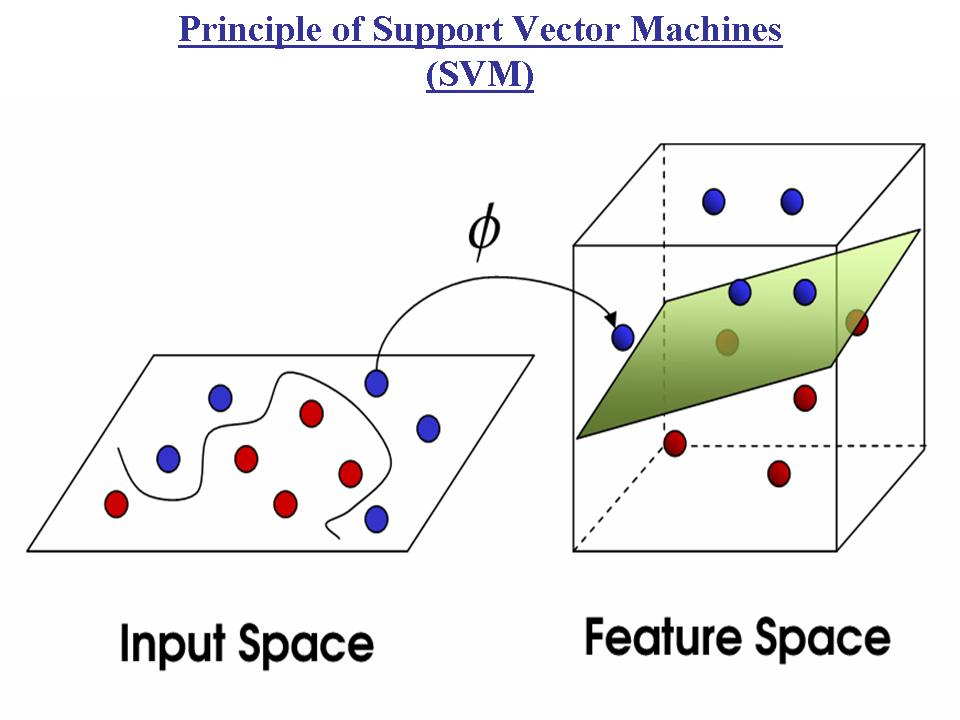

In [72]:
Image(filename='svm.jpg')

I have implemented three supervised learning models namely Support vector machines, Adaptive boosting, and Naive Bayes (BernoulliNB) to predict those students who may need early intervention. After considering training time, prediction time and F1 score on the test dataset I choose SVM as the single best model to predict those students who needs early intervention. 

SVM gives the best F1 score on the test dataset for all the three training sample size (100,200, and 300). The training time for SVM is also low as compared to AdaBoost and almost comparable to Naive bayes. 

For our problem given the data and limited resources SVM with rbf kernel gives the best performance in terms of prediction power.

### Support Vector Machines: 

SVM more accurately called support vector classifier is a discriminative ML model that seperates training data into two classes such that they are maximally apart as shown in the figures above. Its also know as maximum margin classifier for the same reason. If the data is linearly seperable then an optimal line (hyperplane for higher dimensions) is drawn between the two classes to seperate them. If they are not linearly seperable then a kernel function is used to transform the data in a higher plane where it is linearly seperable. 

Once the parameters of this hyper plane are computed it is used to classify new data points. The output of training a SVM model is an equation of a hyperplane seprating the classes. Predictions on new input data is computed by using the equation of hyperplane. Based on this computed value, using an optimal threshold, decision is made whether this new student needs interventon or not.

After fine tuning SVM for entire dataset using grid search for the hyper parameter 'C', 'kernel', and 'gamma', F1 score on this training set is 0.816 which is better than 0.8 of the untuned svm model.  

